## Packages

In [96]:
import os.path as osp
from pathlib import Path
from time import time
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import librosa

from IPython.display import Audio, clear_output, display

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

## Arguments

In [27]:
bert_model = "bert-base-uncased"
pretrained_model = "../models/bert_pretrained/"
transcripts_path = "../outputs/all_transcripts.csv"
device = "cpu"

## User-Defined Functions

In [15]:
class GrandStand_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, info):
        self.encodings = encodings
        self.labels = labels
        self.info = info

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        item["info"] = self.info[idx]
        return item

    def __len__(self):
        return len(self.labels)

## Load Transcript

In [7]:
transcripts = pd.read_csv(transcripts_path)
transcripts.sample(n=5)

,Unnamed: 0,file,line,speaker,start,end,duration,start_idx,end_idx,text
1669,45,19-968.wav,239,Sonia_Sotomayor,4048.92,4105.00,56.08,64782720,65680000,"-- my -- my problem, counsel, is that then you..."
812,1,19-351.wav,9,Clarence_Thomas,244.40,296.88,52.48,3910400,4750080,"Thank you, Mr. Chief Justice. Counsel, the -- ..."
108,21,18-1447.wav,128,Neil_Gorsuch,2340.52,2382.56,42.04,37448320,38120960,"Mr. Snyder, I guess I'm curious about this: Is..."
1466,3,19-8709.wav,25,Stephen_G_Breyer,645.26,683.18,37.92,10324160,10930880,That's why I asked what's the trial record. Yo...
2053,1,20-315.wav,4,John_G_Roberts_Jr,215.08,244.74,29.66,3441280,3915840,"Well, but usually -- I mean, there are other p..."


In [8]:
print("# Cases:", transcripts["file"].nunique())
print("# Speech Segments:", transcripts.shape[0])

# Cases: 56
# Speech Segments: 2545


In [12]:
text = transcripts["text"].tolist()
metadata = transcripts.apply(lambda x: (x["file"], x["line"]), axis=1).tolist()
fake_labels = [0 for i in range(transcripts.shape[0])]

## Load BERT Pre-Trained Weights

In [11]:
tokenizer = BertTokenizer.from_pretrained(bert_model)

In [84]:
st = time()

scotus_encoder = tokenizer(text, truncation=True, padding=True)
scotus_dataset = GrandStand_Dataset(scotus_encoder, fake_labels, metadata)

print(f"{round(time() - st, 2)}s")

4.34s


In [85]:
st = time()
model = BertForSequenceClassification.from_pretrained(bert_model, num_labels=1)

model.load_state_dict(torch.load("../models/bert_pretrained/BERTforGS"))
model.eval()
model.to(device)

print(f"{round(time() - st, 2)}s")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

1.73s


## Generate Scores

In [ ]:
st = time()

inputs = []
grandstanding_scores = []
for i, batch in enumerate(scotus_dataset):
    if i % 10 == 0:
        clear_output(wait=True)
        print("Item", i)
        print(f"Elapsed Time: {round(time() - st, 2)}s")
    with torch.no_grad():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        file_info = batch["info"]
        outputs = model(
            input_ids.reshape(1, -1), attention_mask=attention_mask.reshape(1, -1)
        )
        score = outputs.logits[0].item()
        grandstanding_scores.append((file_info, score))

print(f"Total Time: {round(time() - st, 2)}s")

In [90]:
gs_df = pd.DataFrame(
    data=[(i[0], i[1], s) for (i, s) in grandstanding_scores],
    columns=["file", "line", "gs_score"],
)
gs_df.sample(n=5)

,file,line,gs_score
2300,20-444.wav,97,-0.387948
1213,19-547.wav,66,-0.677721
2541,65-orig.wav,165,0.143898
197,18-956.wav,182,-0.593576
897,19-357.wav,224,0.204544


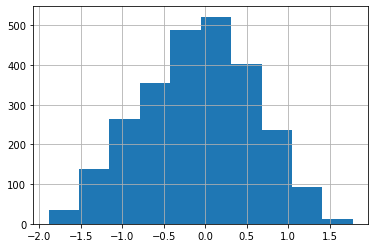

In [95]:
_ = gs_df["gs_score"].hist()

In [91]:
gs_df.to_csv("../outputs/bert_scores.csv")